In [1]:
import sys
sys.path.append('..')
from pathlib import PurePath
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import modules
from models import *
from modules.data_io import (
    ALL_DATA,
    load_data_marginals,
    load_data_means,
    load_data_covariances,
    load_single_species_data,
    NUM_TIMES,
    NUM_REPLICAS,
    NUM_MEASUREMENTS,
    CONDITIONS,
    REPLICA_LABELS,
    TIME_LABELS
)
import inspect
import pandas as pd

plt.rc("axes", grid="on")

# Path to the codes for single-gene analysis
PATH = PurePath(inspect.getfile(modules)).parents[1] / "single_gene_analysis"

T_MEASUREMENTS = 3600*np.array([0, 0.5, 1, 2, 4])
SPECIES = ['il1b', 'tnfa']
MODELS = ['2SA', '2SB', '3SA', '3SB', '3SC', '3SD']

DATA_MEANS = load_data_means()
DATA_COVARIANCES = load_data_covariances()
DATA_MARGINALS = load_data_marginals()

In [2]:
def load_marginal_fit(model_class, species, condition):
    with np.load(PATH / f'predictions/single_cond_fits/predictions_{model_class}_{species.lower()}_{condition}'
                        f'.npz') as f:
        marginal_snapshots = []
        for i in range(0, len(T_MEASUREMENTS)):
            marginal_snapshots.append(f[f'p{i}'])
    return marginal_snapshots

def load_mean_var_fit(model_class, species, condition):
    with np.load(PATH / f'predictions/single_cond_fits/predictions_{model_class}_{species.lower()}_{condition}'
                        f'.npz') as f:
        means = f['mean']
        vars = f['var']
        times = f['tnodes'] - ThreeStateSingleGeneA.T0

    return {'times': times, 'means': means, 'vars': vars}

mean_var_fits = {}
for model in MODELS:
    mean_var_fits[model] = {}
    for species in SPECIES:
        mean_var_fits[model][species] = load_mean_var_fit(model, species, "NoInhibitors")

marginal_fits = {}
for model in MODELS:
    marginal_fits[model] = {}
    for species in SPECIES:
        marginal_fits[model][species] = load_marginal_fit(model, species, "NoInhibitors")



In [3]:
d = []

for m, model in enumerate(MODELS):
    d.append([model])
    for s, species in enumerate(SPECIES):
        data = load_single_species_data("NoInhibitors", species)
        ll = 0
        ndata = 0
        for j in range(len(T_MEASUREMENTS)):
            xdata = data[j]
            p = marginal_fits[model][species][j]
            p[p<1e-16] = 1e-16
            xdata[xdata>=len(p)] = len(p)-1
            ll += np.sum(np.log(p[xdata]))
            ndata += data[j].size
        if model.startswith("3S"):
            k = 11
        elif model.startswith("C3S"):
            k = 13
        else:
            k = 8
        bic = k*np.log(ndata) - 2*ll
        d[-1] += [ll, bic]

comparison_table = pd.DataFrame(d, columns=["Model", "il1b_fit", "il1b_BIC", "tnfa_fit", "tnfa_BIC"])
print(comparison_table)
comparison_table.to_csv(r'tables/single_gene_models.csv', index = False, header=True)

  Model      il1b_fit       il1b_BIC      tnfa_fit       tnfa_BIC
0   2SA -71606.168137  143287.220139 -61234.157031  122543.197926
1   2SB -72145.632442  144366.148749 -63172.489839  126419.863542
2   3SA -71374.578025  142852.121364 -60818.202475  121739.370263
3   3SB -71441.888354  142986.742022 -61086.196878  122275.359070
4   3SC -71453.014029  143008.993371 -60808.895666  121720.756646
5   3SD -72314.905830  144732.776974 -63271.872460  126646.710233


# Fits to marginal mRNA distributions without inhibitors

In [4]:
species_labels = {'tnfa': rf"TNF-$\alpha$",
                  'il1b': rf"IL-1$\beta$"}

cond_labels = {'NoInhibitors': 'No Inhibitors',
               'MG': 'MG132',
               'U0126': 'U0126',
               'MG_U0126': 'Combined'}
cond_colors = {'NoInhibitors': 'red', 'MG': 'blue', 'U0126': 'orange', 'MG_U0126': 'darkgreen'}
cond_ls = {'NoInhibitors': '-', 'MG': '-.', 'U0126': '--', 'MG_U0126': ':'}
cond_markers = {
        "NoInhibitors": "v",
        "MG": "o",
        "U0126": "x",
        "MG_U0126": "*"
}

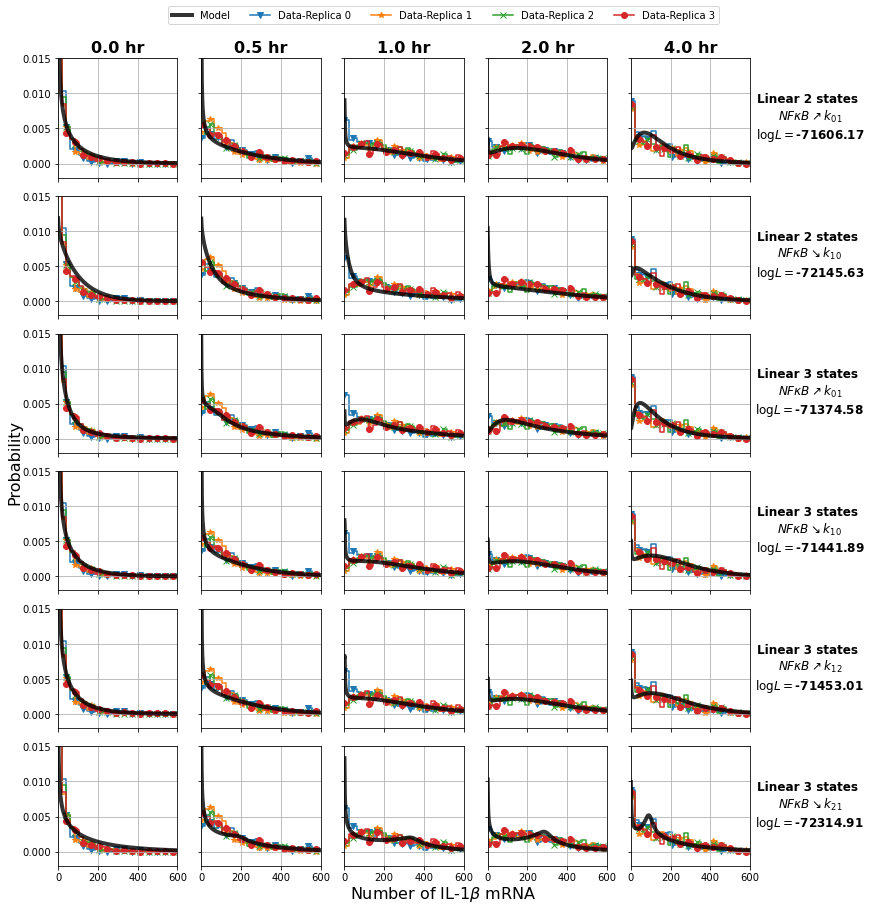

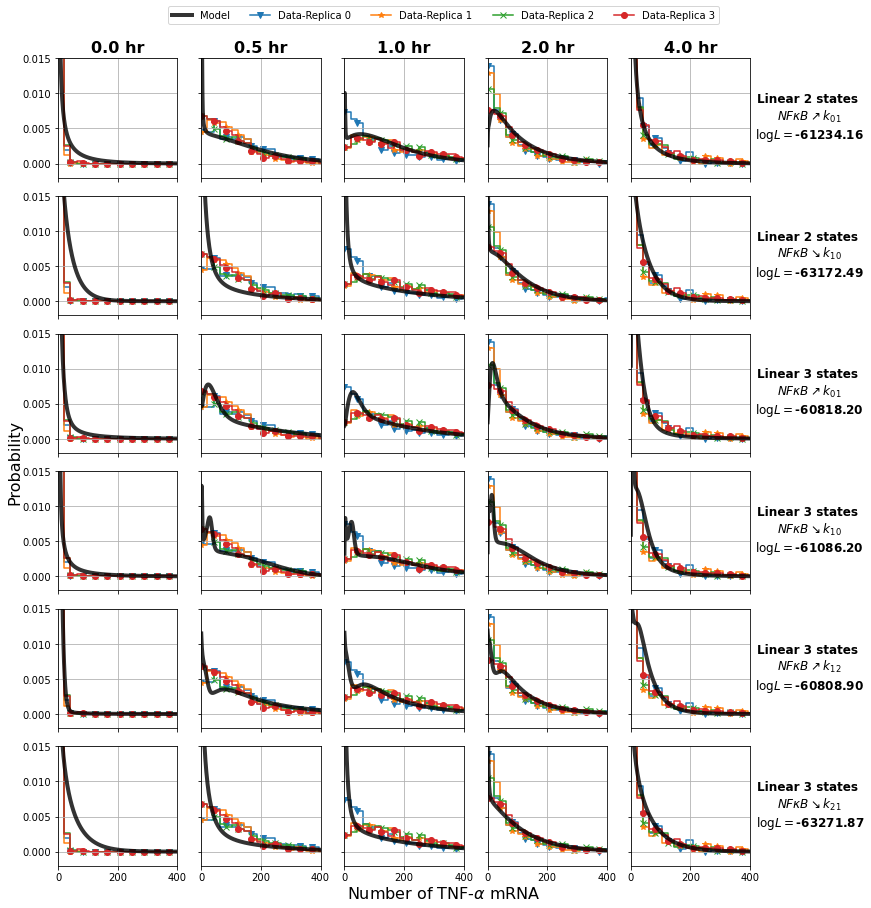

In [5]:
xlimits = {'tnfa': [0, 400], 'il1b': [0, 600]}
model_strings = {'2SA': f'Linear 2 states \n' + r'$NF\kappa{{B}} \nearrow k_{{01}}$',
                 '2SB': f'Linear 2 states \n' + r'$NF\kappa{{B}} \searrow k_{{10}}$',
                 '3SA': f'Linear 3 states \n' + r'$NF\kappa{{B}} \nearrow k_{{01}}$',
                 '3SB': f'Linear 3 states \n' + r'$NF\kappa{{B}} \searrow k_{{10}}$',
                 '3SC': f'Linear 3 states \n' + r'$NF\kappa{{B}} \nearrow k_{{12}}$',
                 '3SD': f'Linear 3 states \n' + r'$NF\kappa{{B}} \searrow k_{{21}}$',
                 'C3SA': f'Circular 3 states \n' + r'$NF\kappa{{B}} \nearrow k_{{01}}$',
                 'C3SB': f'Circular 3 states \n' + r'$NF\kappa{{B}} \searrow k_{{10}}$'}
rep_markers = ['v', '*', 'x', 'o']
for species in SPECIES:
    fig, axes = plt.subplots(len(MODELS), len(T_MEASUREMENTS), sharex=True, sharey=True)
    fig.set_size_inches(12, 12)
    fig.set_tight_layout(True)
    for i, model in enumerate(MODELS):
        for j in range(len(T_MEASUREMENTS)):
            # Model predictions
            p_model = np.copy(marginal_fits[model][species][j])
            p_model[p_model < 1.0e-8] = 1.0e-8

            fit_label = "Model"
            xmax = len(p_model)
            axes[i,j].plot(p_model, color="k", label=fit_label, linewidth=4, alpha=0.8)
            axes[i,j].set_xlim(xlimits[species])

            # DATA MARGINALS
            for rep in range(0, 4):
                data = load_single_species_data("NoInhibitors", species, rep)
                fit_h, fit_edges = np.histogram(data[j],
                                            bins=np.linspace(0, 600, 600//20),
                                            density=True)
                axes[i,j].plot(fit_edges[:-1], fit_h,
                               label=f"Data-Replica {rep}",
                               marker=rep_markers[rep], markevery=2,
                               drawstyle='steps-post', zorder=0)
            # fit_h, fit_edges = np.histogram(data[j],
            #                                 bins=np.linspace(0, 600, 600//20),
            #                                 density=True)
            # axes[i,j].plot(fit_edges[:-1], fit_h, label=f"Data",
            #                    markevery=2,
            #                    drawstyle='steps-post', zorder=0)

            axes[i,j].set_xlim(xlimits[species])
            axes[i,j].set_ylim([-0.002, 0.015])

            if i == 0:
                axes[i,j].set_title(f'{T_MEASUREMENTS[j]/3600} hr',
                                    fontsize=16,
                                    fontweight='bold')
            # elif i == axes.shape[0]-1:
            #     axes[i,j].set_xlabel('RNA copy number')
            #
            # if j == 0:
            #     axes[i,j].set_ylabel('Probability')
            if j == 4:
                axes[i,j].annotate(f"{model_strings[model]}\n"
                                   rf"$\log{{L}}=${comparison_table[f'{species}_fit'].iloc[i]: .2f}",
                                   xy=(1.5, 0.5), xycoords="axes fraction",
                                   rotation=0,
                                   horizontalalignment='center',
                                   va='center',
                                   fontsize=12,
                                   fontweight="bold")

    h, l = axes[0,0].get_legend_handles_labels()

    fig.text(0.5, -0.005, f"Number of "
                        rf"{species_labels[species]}"
                        rf" mRNA", ha="center", fontsize=16)
    fig.text(-0.005, 0.5, f"Probability", va="center",
             rotation="vertical", fontsize=16)

    fig.legend(h, l,
               bbox_to_anchor=(0, 1, 1, 2),
               loc="lower center",
               ncol=5)

    fig.savefig(PATH / f'figs/{species.lower()}_NoInhibitor_fits.png',
                dpi = 500,
                bbox_inches='tight')

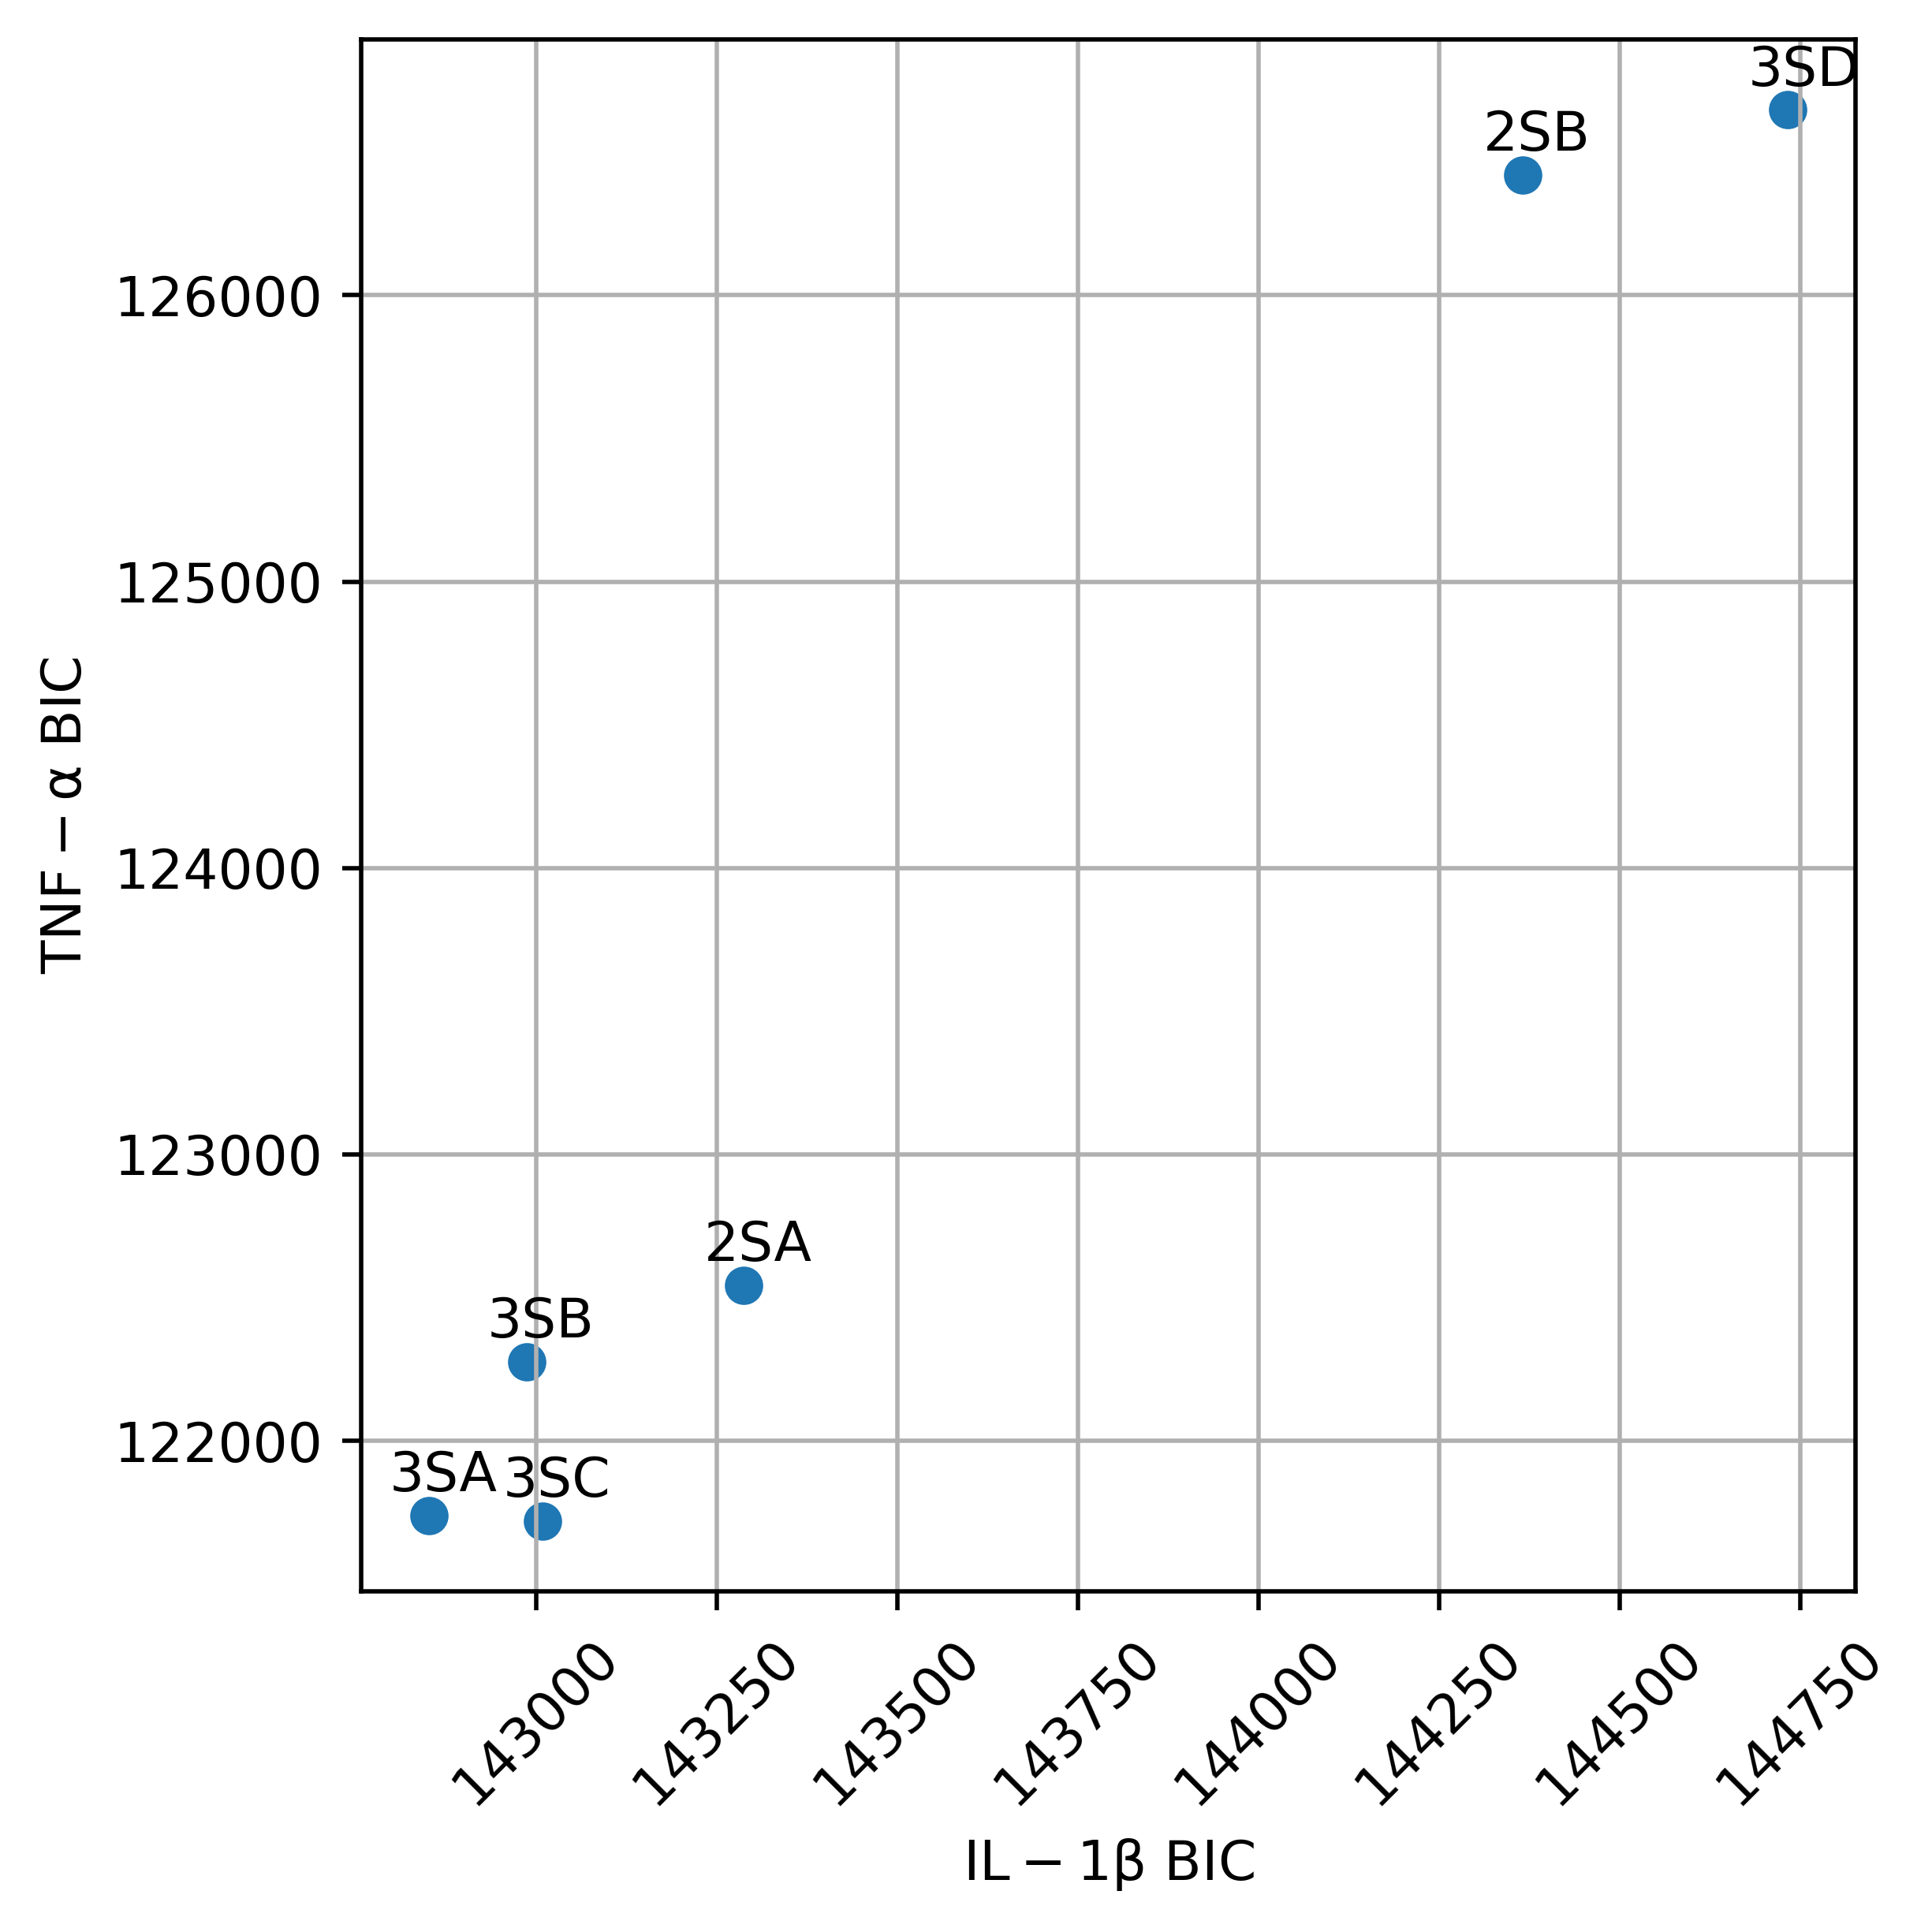

In [6]:
fig = plt.figure(tight_layout=True, dpi=500, figsize=(5,5))
ax = fig.add_subplot()
ax.scatter(comparison_table["il1b_BIC"], comparison_table["tnfa_BIC"])
for i in range(comparison_table.shape[0]):
    model = comparison_table.iloc[i]["Model"]
    bic_il1b = comparison_table.iloc[i]["il1b_BIC"]
    bic_tnfa = comparison_table.iloc[i]["tnfa_BIC"]
    ax.annotate(model, (bic_il1b-55, bic_tnfa+85))
ax.tick_params(rotation=45, axis="x")
ax.set_xlabel(r"$\operatorname{IL-1\beta}$ BIC")
ax.set_ylabel(r"$\operatorname{TNF-\alpha}$ BIC")
fig.savefig("figs/single_gene_bic.png")

# NFkB signal fits for different models

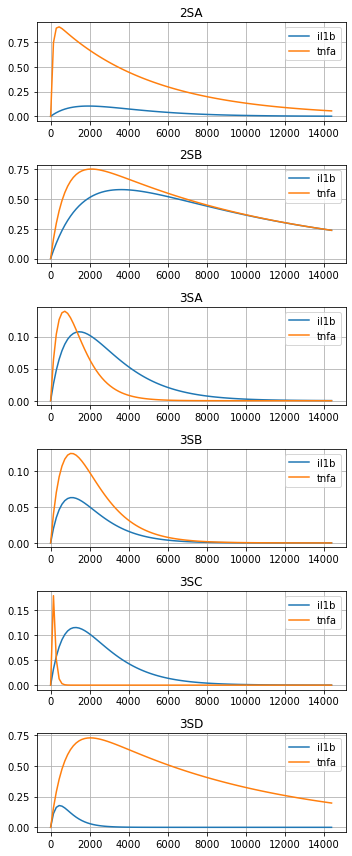

In [7]:
fig, axes = plt.subplots(len(MODELS), 1)
fig.set_tight_layout(True)
fig.set_size_inches(5, 2*len(MODELS))
for i, model in enumerate(MODELS):
    r1 = {}
    r2 = {}
    s = {}
    for species in SPECIES:
        with np.load(f"opt_results/single_cond_fits/bests/{model}_{species}_NoInhibitors_best_1_fits.npz") as _:
            r1[species], r2[species] = 10.0**_["xs"][0,0:2]    
    t = np.linspace(0, 4*3600, 100)
    for species in SPECIES:
        s[species] = np.exp(-r1[species]*t)*(1-np.exp(-r2[species]*t))
        axes[i].plot(t, s[species], label=species)
    axes[i].set_title(model)
    axes[i].legend()
